# Vibe Matcher

In [18]:
!pip install openai pandas scikit-learn matplotlib plotly

In [19]:
import os
import pandas as pd
import numpy as np
import openai
import time
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from google.colab import userdata
from IPython.display import display, HTML

In [20]:
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    openai.api_key = os.environ["OPENAI_API_KEY"]
    print("OpenAI API Key loaded successfully.")
except Exception as e:
    print(f"Error loading API key: {e}")

OpenAI API Key loaded successfully.


In [21]:
data = [
    {
        "name": "Midnight Metro Graffiti Jacket",
        "desc": "A bold, oversized denim jacket with custom neon graffiti art. Perfect for navigating the city streets with an energetic, urban, and chic edge. Features sharp lines and a modern silhouette for true streetwear credentials.",
        "vibes": ["urban", "chic", "energetic", "streetwear"],
        "price_inr": 8999
    },
    {
        "name": "Sunset Wanderer Maxi Dress",
        "desc": "A flowy, floor-length maxi dress in earthy tones of terracotta and sand. Features intricate floral embroidery and a relaxed, bohemian fit. Ideal for festivals, beach walks, and capturing a free-spirited boho vibe.",
        "vibes": ["boho", "festival", "flowy", "earthy"],
        "price_inr": 4599
    },
    {
        "name": "Cashmere Cloud Sweater",
        "desc": "An exceptionally soft, minimalist cashmere sweater in a neutral beige. Its clean lines and cozy, relaxed fit embody quiet luxury. The perfect warm pullover for a minimalist, comfortable, and sophisticated aesthetic.",
        "vibes": ["cozy", "minimalist", "luxury", "neutral", "warm"],
        "price_inr": 12999
    },
    {
        "name": "Crimson Peak Gothic Trench",
        "desc": "A dramatic, floor-length black trench coat in vegan leather. Features silver buckles, a high collar, and a tailored waist. This piece is pure gothic elegance, perfect for a dark, alternative, and mysterious look.",
        "vibes": ["gothic", "dark", "alternative", "dramatic"],
        "price_inr": 11500
    },
    {
        "name": "Ivy League Prep Blazer",
        "desc": "A classic navy blue blazer with brass buttons and a university crest patch. Tailored for a sharp, preppy, and academic look. Pairs perfectly with chinos or a plaid skirt for a timeless, smart-casual style.",
        "vibes": ["preppy", "classic", "academic", "smart-casual"],
        "price_inr": 7499
    },
    {
        "name": "Kinetic Volt Windbreaker",
        "desc": "A lightweight, neon-yellow windbreaker designed for high-performance athletics. Water-resistant and breathable, it's built for running, hiking, and all active, sporty lifestyles. Move freely with an energetic, athletic fit.",
        "vibes": ["sporty", "athletic", "energetic", "active"],
        "price_inr": 5299
    },
    {
        "name": "Soho Artist Linen Shirt",
        "desc": "An effortlessly chic, oversized white linen shirt. It's breathable, comfortable, and has an artistic, slightly rumpled look. A versatile piece for a minimalist, urban, or creative wardrobe.",
        "vibes": ["minimalist", "chic", "artistic", "urban", "linen"],
        "price_inr": 3999
    },
    {
        "name": "Hygge Comfort Knit Scarf",
        "desc": "A huge, chunky-knit wool scarf in a warm oatmeal color. Incredibly soft and perfect for wrapping up in. The ultimate accessory for a cozy, warm, and comfortable winter vibe. Pure hygge.",
        "vibes": ["cozy", "warm", "comfortable", "knit"],
        "price_inr": 2999
    }
]

df = pd.DataFrame(data)

print("--- Product Dataset Loaded ---")
display(df[['name', 'vibes', 'price_inr']])

--- Product Dataset Loaded ---


,name,vibes,price_inr
0,Midnight Metro Graffiti Jacket,"[urban, chic, energetic, streetwear]",8999
1,Sunset Wanderer Maxi Dress,"[boho, festival, flowy, earthy]",4599
2,Cashmere Cloud Sweater,"[cozy, minimalist, luxury, neutral, warm]",12999
3,Crimson Peak Gothic Trench,"[gothic, dark, alternative, dramatic]",11500
4,Ivy League Prep Blazer,"[preppy, classic, academic, smart-casual]",7499
5,Kinetic Volt Windbreaker,"[sporty, athletic, energetic, active]",5299
6,Soho Artist Linen Shirt,"[minimalist, chic, artistic, urban, linen]",3999
7,Hygge Comfort Knit Scarf,"[cozy, warm, comfortable, knit]",2999


In [22]:
def get_embedding(text, model="text-embedding-ada-002"):
    try:
        response = openai.embeddings.create(
            input=[text.replace("\n", " ")],
            model=model
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error in get_embedding: {e}")
        return None

In [23]:
print("Generating embeddings for all product descriptions...")

df['embedding'] = df['desc'].apply(get_embedding)

if df['embedding'].isnull().any():
    print("Warning: Some embeddings could not be generated.")
else:
    print("Embeddings generated successfully for all products.")

product_embeddings = np.array(df['embedding'].tolist())
print(f"Embedding matrix shape: {product_embeddings.shape}")

Generating embeddings for all product descriptions...
Embeddings generated successfully for all products.
Embedding matrix shape: (8, 1536)


> This 2D scatter plot (using t-SNE) visualizes the 'embedding space.' Products with similar vibes (and descriptions) should appear clustered together, showing the model understands their semantic relationships.

In [24]:
tsne = TSNE(n_components=2, perplexity=3, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(product_embeddings)

tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['name'] = df['name']
tsne_df['main_vibe'] = df['vibes'].apply(lambda x: x[0])
tsne_df['price_inr'] = df['price_inr']

fig = px.scatter(tsne_df,
                 x='tsne-2d-one',
                 y='tsne-2d-two',
                 color='main_vibe',
                 size='price_inr',
                 hover_data=['name', 'main_vibe'],
                 title='2D t-SNE Projection of Product Embeddings')

fig.show()

In [25]:
def find_vibe_matches(query_vibe, top_n=3, match_threshold=0.78, std_dev_threshold=2.0):
    print("\n" + "="*70)
    print(f"Querying for vibe: '{query_vibe}'")

    query_start_time = time.time()
    query_embedding = get_embedding(query_vibe)
    query_embed_time = time.time() - query_start_time

    if query_embedding is None:
        print("Error: Could not generate embedding for query.")
        return pd.DataFrame(), 0, 0, np.array([])

    search_start_time = time.time()
    query_vec = np.array(query_embedding).reshape(1, -1)
    sim_scores = cosine_similarity(query_vec, product_embeddings)[0]
    search_time = time.time() - search_start_time

    results_df = df.copy()
    results_df['similarity_score'] = sim_scores
    results_df = results_df.sort_values(by='similarity_score', ascending=False)

    mean_score = np.mean(sim_scores)
    std_dev_score = np.std(sim_scores)
    top_match_score = results_df.iloc[0]['similarity_score']

    is_strong_match = (top_match_score > match_threshold)

    is_outlier_match = False
    if std_dev_score > 0.01:
        is_outlier_match = (top_match_score > (mean_score + std_dev_threshold * std_dev_score))

    total_latency = query_embed_time + search_time

    print("\n--- Match Report ---")

    if is_strong_match and is_outlier_match:
        print(f"Status: Success (Strong Match)")
    elif is_strong_match and not is_outlier_match:
        print(f"Status: Ambiguous Match (Top score {top_match_score:.4f} is not a clear outlier)")
        print(f"       (Did not beat {std_dev_threshold} std devs above mean {mean_score:.4f})")
    else:
        print(f"Status: Fallback (No strong match found > {match_threshold})")

    print(f"Top Match Score: {top_match_score:.4f}")
    print(f"Score Mean: {mean_score:.4f} / Std Dev: {std_dev_score:.4f}")
    print(f"Total Latency: {total_latency:.4f} seconds")
    print(f" (Embedding: {query_embed_time:.4f}s, Search: {search_time:.4f}s)")

    top_results = results_df.head(top_n)[['name', 'price_inr', 'desc', 'similarity_score']]

    print("\n--- Top 3 Matches ---")
    display(top_results)

    return top_results, total_latency, top_match_score, sim_scores

In [26]:
run_mode = ''
while run_mode not in ['1', '2']:
    print("Select an option:")
    print("  [1] Run Default Test Queries ")
    print("  [2] Enter Custom Queries ")
    run_mode = input("Enter your choice (1 or 2): ")

show_plots = False
eval_results = []
all_scores_data = []

Select an option:
  [1] Run Default Test Queries 
  [2] Enter Custom Queries 
Enter your choice (1 or 2): 1


In [27]:
if run_mode == '1':
    print("\nRunning Default Test Queries...")
    show_plots = True

    default_queries = [
        "energetic urban chic streetwear",
        "free-spirited boho festival vibe",
        "cozy warm minimalist sweater",
        "underwater alien scuba gear",
        "abcds ags aef wthh"
    ]

    for query in default_queries:
        matches, latency, score, all_scores = find_vibe_matches(query)
        eval_results.append({'query': query, 'latency': latency, 'top_score': score, 'mean': np.mean(all_scores), 'std': np.std(all_scores)})
        for s in all_scores:
            all_scores_data.append({'query': query, 'score': s})

    print("\n" + "="*70)
    print("Default Test Run Complete.")

elif run_mode == '2':
    print("Enter your vibe ")
    print("Type 'exit' to quit and generate analysis plots.")

    while True:
        user_query = input("\nEnter your vibe query: ")

        if user_query.lower() == 'exit':
            if eval_results:
                show_plots = True
                print("Generating analysis plots for your custom queries...")
            else:
                print("No queries were run, skipping plot generation.")
            break

        matches, latency, score, all_scores = find_vibe_matches(user_query)

        eval_results.append({'query': user_query, 'latency': latency, 'top_score': score, 'mean': np.mean(all_scores), 'std': np.std(all_scores)})
        for s in all_scores:
            all_scores_data.append({'query': user_query, 'score': s})


Running Default Test Queries...

Querying for vibe: 'energetic urban chic streetwear'

--- Match Report ---
Status: Success (Strong Match)
Top Match Score: 0.8787
Score Mean: 0.8238 / Std Dev: 0.0252
Total Latency: 0.3521 seconds
 (Embedding: 0.3459s, Search: 0.0062s)

--- Top 3 Matches ---


,name,price_inr,desc,similarity_score
0,Midnight Metro Graffiti Jacket,8999,"A bold, oversized denim jacket with custom neo...",0.878742
5,Kinetic Volt Windbreaker,5299,"A lightweight, neon-yellow windbreaker designe...",0.837163
6,Soho Artist Linen Shirt,3999,"An effortlessly chic, oversized white linen sh...",0.830057



Querying for vibe: 'free-spirited boho festival vibe'

--- Match Report ---
Status: Success (Strong Match)
Top Match Score: 0.8412
Score Mean: 0.7881 / Std Dev: 0.0240
Total Latency: 0.3221 seconds
 (Embedding: 0.3208s, Search: 0.0013s)

--- Top 3 Matches ---


,name,price_inr,desc,similarity_score
1,Sunset Wanderer Maxi Dress,4599,"A flowy, floor-length maxi dress in earthy ton...",0.841175
6,Soho Artist Linen Shirt,3999,"An effortlessly chic, oversized white linen sh...",0.802486
0,Midnight Metro Graffiti Jacket,8999,"A bold, oversized denim jacket with custom neo...",0.798131



Querying for vibe: 'cozy warm minimalist sweater'

--- Match Report ---
Status: Success (Strong Match)
Top Match Score: 0.9133
Score Mean: 0.8360 / Std Dev: 0.0364
Total Latency: 0.6450 seconds
 (Embedding: 0.6438s, Search: 0.0013s)

--- Top 3 Matches ---


,name,price_inr,desc,similarity_score
2,Cashmere Cloud Sweater,12999,"An exceptionally soft, minimalist cashmere swe...",0.913267
7,Hygge Comfort Knit Scarf,2999,"A huge, chunky-knit wool scarf in a warm oatme...",0.866110
6,Soho Artist Linen Shirt,3999,"An effortlessly chic, oversized white linen sh...",0.853607



Querying for vibe: 'underwater alien scuba gear'

--- Match Report ---
Status: Fallback (No strong match found > 0.78)
Top Match Score: 0.7662
Score Mean: 0.7457 / Std Dev: 0.0124
Total Latency: 0.3190 seconds
 (Embedding: 0.3177s, Search: 0.0014s)

--- Top 3 Matches ---


,name,price_inr,desc,similarity_score
5,Kinetic Volt Windbreaker,5299,"A lightweight, neon-yellow windbreaker designe...",0.766196
0,Midnight Metro Graffiti Jacket,8999,"A bold, oversized denim jacket with custom neo...",0.759166
3,Crimson Peak Gothic Trench,11500,"A dramatic, floor-length black trench coat in ...",0.750564



Querying for vibe: 'abcds ags aef wthh'

--- Match Report ---
Status: Fallback (No strong match found > 0.78)
Top Match Score: 0.7437
Score Mean: 0.7261 / Std Dev: 0.0102
Total Latency: 0.1964 seconds
 (Embedding: 0.1951s, Search: 0.0013s)

--- Top 3 Matches ---


,name,price_inr,desc,similarity_score
4,Ivy League Prep Blazer,7499,A classic navy blue blazer with brass buttons ...,0.743667
0,Midnight Metro Graffiti Jacket,8999,"A bold, oversized denim jacket with custom neo...",0.736079
5,Kinetic Volt Windbreaker,5299,"A lightweight, neon-yellow windbreaker designe...",0.733974



Default Test Run Complete.


In [28]:
if show_plots and eval_results:
    eval_df = pd.DataFrame(eval_results)
    all_scores_df = pd.DataFrame(all_scores_data)

    GOOD_MATCH_THRESHOLD = 0.78
    STD_DEV_THRESHOLD = 2.0

    eval_df['is_strong_match'] = eval_df['top_score'] > GOOD_MATCH_THRESHOLD
    eval_df['is_outlier_match'] = eval_df['top_score'] > (eval_df['mean'] + STD_DEV_THRESHOLD * eval_df['std'])
    eval_df['is_good_match'] = eval_df['is_strong_match'] & eval_df['is_outlier_match']

    print("\n" + "="*70)
    print("--- Evaluation Summary ---")
    display(eval_df[['query', 'top_score', 'mean', 'std', 'is_good_match']])
else:
    print("\nNo analysis to display. Run queries in Mode 1 or Mode 2 to generate plots.")


--- Evaluation Summary ---


,query,top_score,mean,std,is_good_match
0,energetic urban chic streetwear,0.878742,0.823765,0.025184,True
1,free-spirited boho festival vibe,0.841175,0.788114,0.024049,True
2,cozy warm minimalist sweater,0.913267,0.836008,0.036389,True
3,underwater alien scuba gear,0.766196,0.745719,0.012421,False
4,abcds ags aef wthh,0.743667,0.726146,0.010242,False


> This bar chart shows the total time (in seconds) taken for each test query, including both getting the query embedding and performing the search.

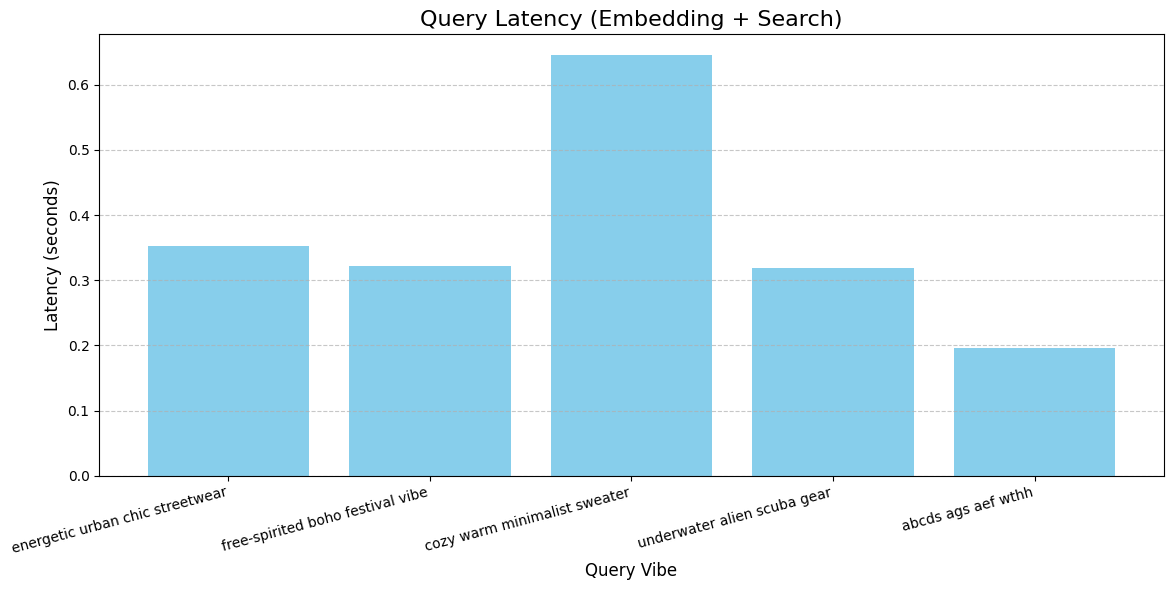

In [29]:
if show_plots and 'eval_df' in locals():
    plt.figure(figsize=(12, 6))
    plt.bar(eval_df['query'], eval_df['latency'], color='skyblue')
    plt.title('Query Latency (Embedding + Search)', fontsize=16)
    plt.xlabel('Query Vibe', fontsize=12)
    plt.ylabel('Latency (seconds)', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

> This bar chart displays the similarity score of the single best match for each query. Green bars indicate a 'good' match (met both thresholds), while red bars indicate a 'weak' or 'ambiguous' match.

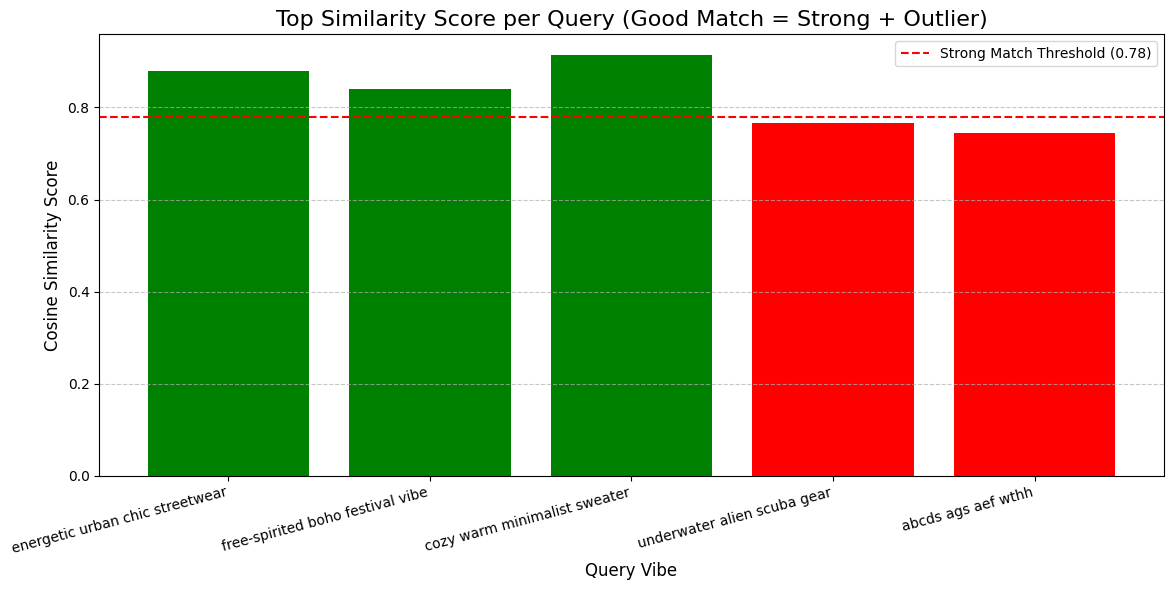

In [30]:
if show_plots and 'eval_df' in locals():
    plt.figure(figsize=(12, 6))
    colors = ['g' if x else 'r' for x in eval_df['is_good_match']]
    plt.bar(eval_df['query'], eval_df['top_score'], color=colors)

    plt.axhline(y=GOOD_MATCH_THRESHOLD, color='r', linestyle='--', label=f'Strong Match Threshold ({GOOD_MATCH_THRESHOLD})')
    plt.title('Top Similarity Score per Query (Good Match = Strong + Outlier)', fontsize=16)
    plt.xlabel('Query Vibe', fontsize=12)
    plt.ylabel('Cosine Similarity Score', fontsize=12)
    plt.legend()
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

> This box plot shows the *full distribution* of similarity scores for all 8 products against each test query. It helps visualize how well each query isolates the correct item(s) from the rest.

In [31]:
if show_plots and 'all_scores_df' in locals():
    fig = px.box(all_scores_df,
                 x='query',
                 y='score',
                 color='query',
                 title='Distribution of All Similarity Scores per Query',
                 points='all')

    fig.update_layout(
        xaxis_title="Test Query",
        yaxis_title="Similarity Score"
    )
    fig.show()

# Detailed product descriptions with strong vibe keywords greatly improve embedding accuracy.
# Instead of a flat 0.7 cutoff, use adaptive or statistical thresholds to filter out weak or random matches.
# Move from brute-force cosine search to a vector database (like Pinecone) for faster, scalable querying.
# Combine semantic (vibe) search with keyword or filter-based logic for more precise, user-friendly results.



